# Network Visualizations

In [1]:
import os
os.chdir('/app/Pogona_realtime/Arena')

## Imports

In [2]:
import numpy as np
import pandas as pd
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.widgets import Slider, Button
import seaborn as sns
#from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv
from scipy.stats import pearsonr

from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib

In [3]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

## Load network

In [4]:
WEIGHTS_DIR = "Prediction/traj_models" 
MODELS_JSON_PATH = os.path.join(WEIGHTS_DIR, "models_params.json")

def weights_path_for(net_name, suffix='best'):
    return os.path.join(WEIGHTS_DIR, f"{net_name}_{suffix}.pth")

In [5]:
with open(MODELS_JSON_PATH, 'r') as fp:
    models_json = json.load(fp)

In [6]:
name = "GRUEncDecSched_1007-1950_i20_o20_h350_l1_z1.2_sched"

In [7]:
net_params = models_json[name]['network_params']

net = seq2seq_predict.GRUEncDec(output_seq_size=net_params['out_seq_len'], 
                                hidden_size=net_params['hidden_size'],
                                GRU_layers=net_params['rnn_layers'],
                                tie_enc_dec=False, use_gru_cell=True, 
                                dropout=net_params['dropout'])

net.load_state_dict(torch.load(weights_path_for(name)))

<All keys matched successfully>

## Linear layer

In [8]:
weights_lin = list(net.linear.parameters())[0]
biases_lin = list(net.linear.parameters())[1]

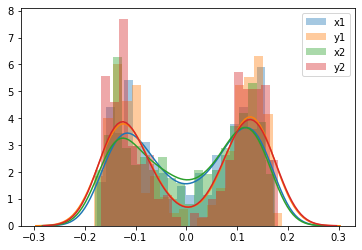

In [9]:
for i in range(weights_lin.size(0)):
    sns.distplot(weights_lin.detach()[i], bins=20, label=net_params['output_labels'][i])
plt.legend()

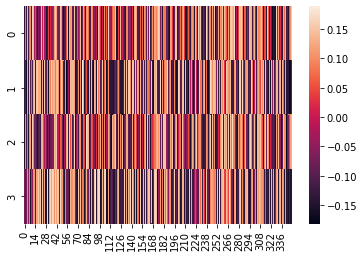

In [10]:
sns.heatmap(weights_lin.detach())

# Encoder GRU

In [11]:
weights_enc_input2hidden = list(net.encoderGRU.parameters())[0]
weights_enc_hidden2hidden = list(net.encoderGRU.parameters())[1]
biases_enc_input2hidden = list(net.encoderGRU.parameters())[2]
biases_enc_hidden2hidden = list(net.encoderGRU.parameters())[3]

### Input to Hidden

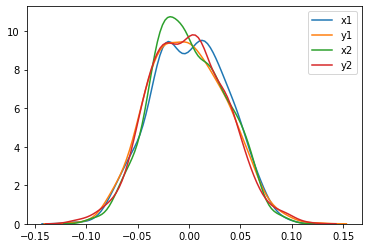

In [12]:
for i, w in enumerate(weights_enc_input2hidden.transpose(0,1)):
    sns.distplot(w.detach(), hist=False, label=net_params['input_labels'][i])
plt.legend()

In [13]:
for w, label in zip(weights_enc_input2hidden.transpose(0,1), net_params['input_labels']):
    w = w.detach()
    print(f"{label}: {(w.abs() > 0.01).sum()}/{w.size(0)}")

x1: 869/1050
y1: 850/1050
x2: 854/1050
y2: 846/1050


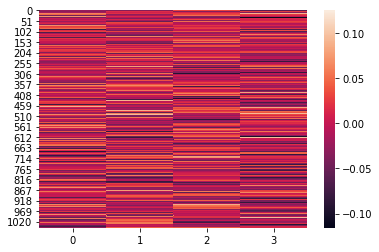

In [14]:
sns.heatmap(weights_enc_input2hidden.detach())

### Hidden to Hidden

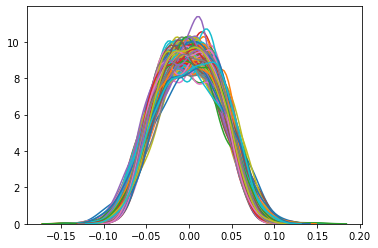

In [15]:
for w in weights_enc_hidden2hidden.transpose(0,1):
    sns.distplot(w.detach(), hist=False)

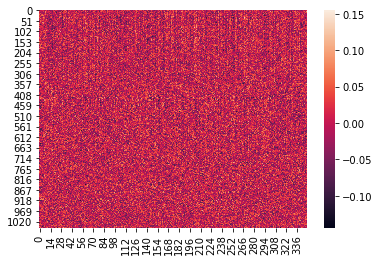

In [16]:
sns.heatmap(weights_enc_hidden2hidden.detach())

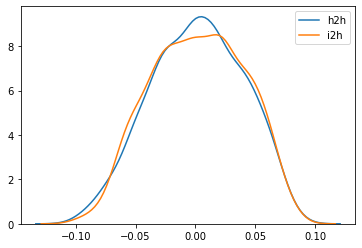

In [17]:
sns.distplot(biases_enc_hidden2hidden.detach(), hist=False, label="h2h")
sns.distplot(biases_enc_input2hidden.detach(), hist=False, label="i2h")
plt.legend()

# Decoder GRU

In [18]:
weights_dec_input2hidden = list(net.decoderGRU.parameters())[0]
weights_dec_hidden2hidden = list(net.decoderGRU.parameters())[1]
biases_dec_input2hidden = list(net.decoderGRU.parameters())[2]
biases_dec_hidden2hidden = list(net.decoderGRU.parameters())[3]

### Input to Hidden

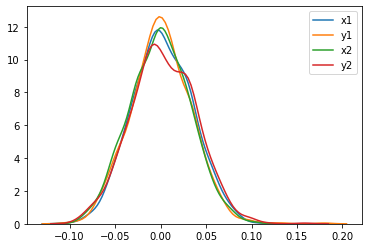

In [19]:
for i, w in enumerate(weights_dec_input2hidden.transpose(0,1)):
    sns.distplot(w.detach(), hist=False, label=net_params['input_labels'][i])
plt.legend()

In [20]:
for w, label in zip(weights_dec_input2hidden.transpose(0,1), net_params['input_labels']):
    w = w.detach()
    print(f"{label}: {(w.abs() > 0.01).sum()}/{w.size(0)}")

x1: 802/1050
y1: 790/1050
x2: 794/1050
y2: 818/1050


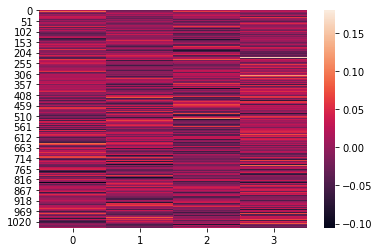

In [21]:
sns.heatmap(weights_dec_input2hidden.detach())

### Hidden to Hidden

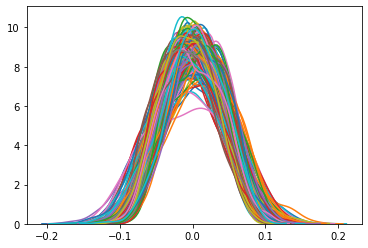

In [22]:
for w in weights_dec_hidden2hidden.transpose(0,1):
    sns.distplot(w.detach(), hist=False)

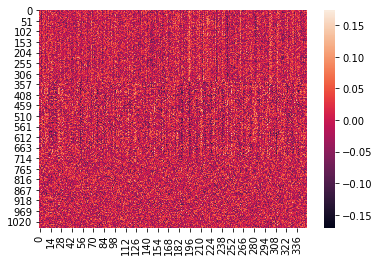

In [23]:
sns.heatmap(weights_dec_hidden2hidden.detach())

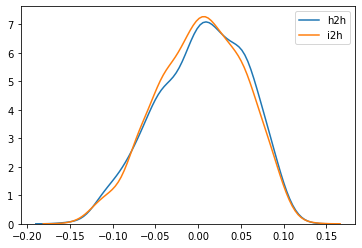

In [24]:
sns.distplot(biases_dec_hidden2hidden.detach(), hist=False, label="h2h")
sns.distplot(biases_dec_input2hidden.detach(), hist=False, label="i2h")
plt.legend()

# Backward Analysis

In [28]:
# concentrate on x1
neg_lin_x1 = weights_lin[0] < 0
pos_lin_x1 = weights_lin[0] > 0
zero_lin_x1 = weights_lin[0] == 0

In [41]:
weights_dec_input2hidden.shape

torch.Size([1050, 4])

In [38]:
h2h_pos = weights_dec_hidden2hidden[:, pos_lin_x1]
h2h_neg = weights_dec_hidden2hidden[:, neg_lin_x1]


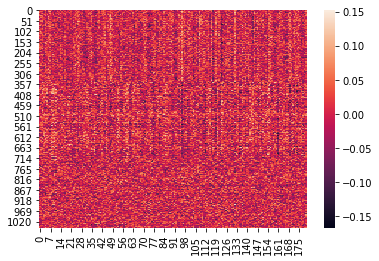

In [39]:
sns.heatmap(h2h_pos.detach())

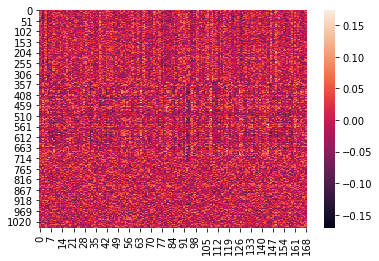

In [40]:
sns.heatmap(h2h_neg.detach())